Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Это все что нам понадобится:

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

     |████████████████████████████████| 5.7MB 6.0MB/s 
     |████████████████████████████████| 112kB 30.5MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35417 sha256=d698ad61569900c25b0b0f36cee977e9d91fa724576460d93da80d2f6ba26cd0
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
!ls images/

dancing.jpg  lisa.jpg  picasso.jpg


**Загрузка изображений**

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [3]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    #print(image)
    image = loader(image)#.unsqueeze(0)
    print(image.shape)
    image = image.unsqueeze(0)
    print(image.shape)
    return image.to(device, torch.float)


style_img = image_loader("images/picasso.jpg")# as well as here
content_img = image_loader("images/lisa.jpg")#измените путь на тот который у вас.


torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


In [5]:
style2_img = image_loader("images/dancing.jpg")#измените путь на тот который у вас.

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


In [6]:
device

device(type='cuda')

In [7]:
mask1=torch.zeros((1,3,128,128))
mask2=mask1+1.
#mask1


In [8]:
for x in range(128):
  for y in range(x):
      mask2[:,:,x,y]=0
#mask2

Выведем то, что было загружено

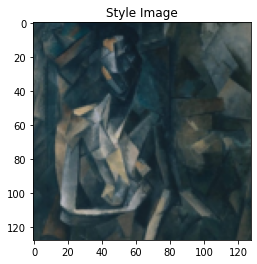

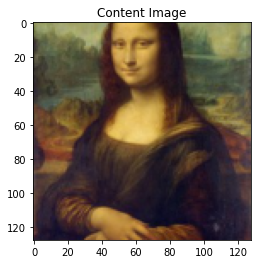

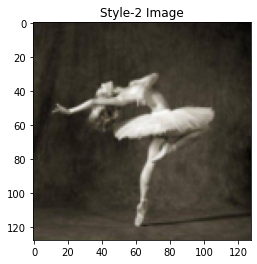

In [34]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style2_img, title='Style-2 Image')

In [14]:
mask3=mask1+1.
for x in range(32):
  for y in range(32):
    if x*x+y*y<32*32:
      mask3[:,:,32-y,64-x]=0
      mask3[:,:,32-y,64+x]=0
      mask3[:,:,32+y,64-x]=0
      mask3[:,:,32+y,64+x]=0
      

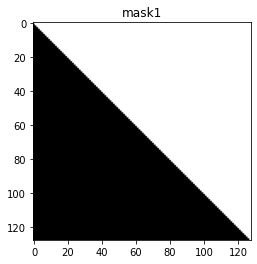

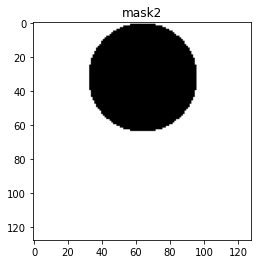

In [15]:
plt.figure()
imshow(mask2, title='mask1')
plt.figure()
imshow(mask3, title='mask2')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [16]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [17]:
def gram_matrix(input,mask):
        batch_size , f_map_num, h, w  = input.size()  # batch size(=1)
        mask_in_size = mask.expand(1,f_map_num,128,128)
        mask_in_size = F.interpolate(mask_in_size,(h,w))

        #print(input.shape,mask_in_size.shape)
        masked_input = input* mask_in_size

        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)
        features = masked_input.view(batch_size * f_map_num, w * h)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product
        #print(G, batch_size * h * w * f_map_num)
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [18]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature,target2_feature,mask):
            super(StyleLoss, self).__init__()
            self.mask = mask.detach()[:,0,:,:]
            self.mask2 = 1.-mask.detach()[:,0,:,:]
            self.target = gram_matrix(target_feature,self.mask).detach()
            self.target2 = gram_matrix(target2_feature,self.mask2).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            #batch_size , f_map_num, h, w  = input.size()  # batch size(=1)
            #masked_input = tourch.mm(input,self.mask.expand(:,f_map_num,h,w)
            G = gram_matrix(input,self.mask)
            G2 = gram_matrix(input,self.mask2)
            self.loss = F.mse_loss(G, self.target) + F.mse_loss(G2, self.target2)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [19]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [20]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)
            #print(self.mean)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [21]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [22]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [23]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style2_img, content_img, mask_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                target2_feature = model(style2_img).detach()
                style_loss = StyleLoss(target_feature,target2_feature,mask_img)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [24]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [25]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style2_img, input_img, mask_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, style2_img, content_img, mask_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

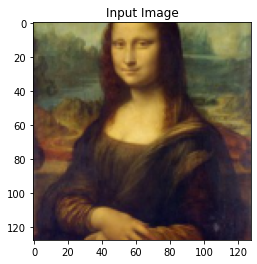

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 4.968396 Content Loss: 6.421282

run [100]:
Style Loss : 2.764196 Content Loss: 5.269474

run [150]:
Style Loss : 2.218752 Content Loss: 5.006100

run [200]:
Style Loss : 1.917956 Content Loss: 4.928783

run [250]:
Style Loss : 1.791621 Content Loss: 4.880615

run [300]:
Style Loss : 1.742058 Content Loss: 4.843086

run [350]:
Style Loss : 1.715016 Content Loss: 4.812160

run [400]:
Style Loss : 1.692236 Content Loss: 4.792177

run [450]:
Style Loss : 1.673350 Content Loss: 4.781145

run [500]:
Style Loss : 1.660769 Content Loss: 4.768885



In [26]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img, mask2.to(device, torch.float))

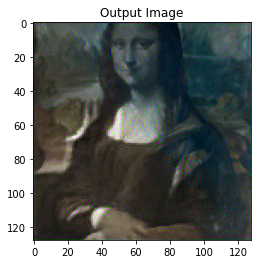

In [27]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

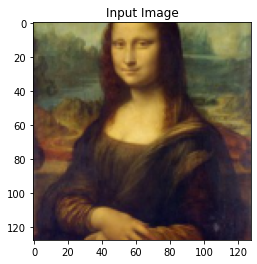

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 8.069212 Content Loss: 7.525764

run [100]:
Style Loss : 3.293072 Content Loss: 5.998839

run [150]:
Style Loss : 2.522910 Content Loss: 5.471882

run [200]:
Style Loss : 2.192976 Content Loss: 5.299096

run [250]:
Style Loss : 2.014407 Content Loss: 5.237486

run [300]:
Style Loss : 1.920766 Content Loss: 5.184905

run [350]:
Style Loss : 1.875866 Content Loss: 5.141976

run [400]:
Style Loss : 1.852182 Content Loss: 5.109665

run [450]:
Style Loss : 1.835611 Content Loss: 5.088272

run [500]:
Style Loss : 1.819186 Content Loss: 5.074321



In [28]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img, mask3.to(device, torch.float))

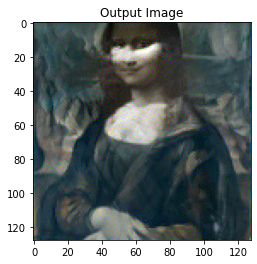

In [29]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

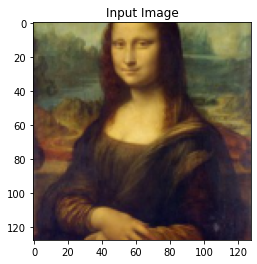

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 5.394445 Content Loss: 6.041176

run [100]:
Style Loss : 2.800542 Content Loss: 5.433996

run [150]:
Style Loss : 2.414017 Content Loss: 5.208830

run [200]:
Style Loss : 2.224983 Content Loss: 5.153992

run [250]:
Style Loss : 2.116859 Content Loss: 5.123614

run [300]:
Style Loss : 2.036031 Content Loss: 5.107978

run [350]:
Style Loss : 1.975858 Content Loss: 5.094030

run [400]:
Style Loss : 1.929676 Content Loss: 5.084113

run [450]:
Style Loss : 1.892535 Content Loss: 5.077179

run [500]:
Style Loss : 1.869332 Content Loss: 5.068578



In [32]:
mask4=1-mask3
cnn = models.vgg19(pretrained=True).features.to(device).eval()
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img, mask4.to(device, torch.float))

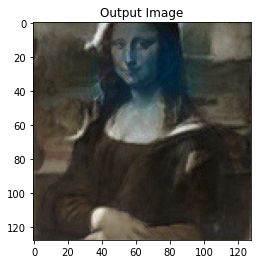

In [33]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()